# 0. 기본 정보
* 코드 작성자: 여서연
* 코드 작성일: 2024-11-16
* 코드 작성 목적: NLP 및 LDA 토픽 모델링

## 참조 코드 - Topic Modeling using LDA

* https://joyhong.tistory.com/138
* https://github.com/FifthSaint/NewsTextMining201903
* https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/
* https://github.com/fastai/course-nlp/blob/master/2-svd-nmf-topic-modeling.ipynb

# 1. 기초 설정

## 사용 라이브러리

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from konlpy.tag import *

In [3]:
import gensim
from gensim import corpora, models
from gensim.models import CoherenceModel

In [4]:
import pyLDAvis
#import pyLDAvis.gensim
import pyLDAvis.gensim_models

In [5]:
import warnings
warnings.filterwarnings('ignore')

# 2. 데이터 처리

## A. 크롤링 데이터 불러오기

In [6]:
week_1st = pd.read_csv("../data/[속보]_['10']월_1기간_news_data.csv")
week_2nd = pd.read_csv("../data/[속보]_['10']월_2기간_news_data.csv")
week_3rd = pd.read_csv("../data/[속보]_['10']월_3기간_news_data.csv")

In [7]:
print(week_1st.shape)
print(week_2nd.shape)
print(week_3rd.shape)

(793, 4)
(800, 4)
(643, 4)


In [8]:
docs1 = []
for idx in range(len(week_1st)):
    docs1.append(week_1st['Title'][idx])

docs2 = []
for idx in range(len(week_2nd)):
    docs2.append(week_2nd['Title'][idx])

docs3 = []
for idx in range(len(week_3rd)):
    docs3.append(week_3rd['Title'][idx])

In [9]:
docs1

['[속보] 이스라엘군, 레바논 남부 접경 마을 20여곳 소개령',
 '[속보] 나토 “한국 등 인태 4개국, 나토 국방장관회의 첫 참석 예정”',
 '[속보] 이시바 시게루, 일본 총리 공식 선출…오늘 새 내각 출범',
 '[속보] 헤즈볼라 "텔아비브 인근 모사드 본부 미사일 공격"',
 '[속보] 이스라엘 "레바논 수도 베이루트 정밀 폭격"',
 '[속보]9월 수출 7.5% 증가…반도체 136억달러 ‘역대 최대’',
 '[속보]광양 23층 아파트서 투신 19세女…극적 구조 성공',
 '[속보] 이스라엘군 "레바논 남부 \'지상 습격\' 시작…헤즈볼라 테러 목표...',
 '[속보]“北으로 돌아갈래”…마을버스 훔쳐 통일대교 건너려던 탈북민...',
 '[속보] 이시바, 일본 102대 총리로 선출…오늘 새 내각 출범',
 '[속보] 이스라엘, 레바논 접경지 봉쇄 거센 포격…지상전 조짐',
 '[속보] 北유엔대사 "합법적 자위권 놓고 과거로 돌아가지 않을 것"',
 '[속보] 윤대통령 "북, 핵무기 사용 기도하는 그날 정권 종말의 날"',
 '[속보] 이시바, 일본 102대 총리로 선출…오늘 새 내각 출범',
 '[속보] 이스라엘군, 레바논 향해 ‘국지적 침공’ 시작···지상전 초읽...',
 '[속보] 이스라엘 "방공망 완벽 준비…이란, 공격시 대가치러야"',
 '[속보]비트코인 3% 대 급락, 6만4000 달러선 깨져…‘이시바 쇼크’ 탓?',
 '[속보] 이스라엘 "레바논 지상작전 되도록 신속히 완료"',
 '[속보] 日이시바 총리 "납북 피해자 문제 해결에 강한 결의"',
 '[속보] "헤즈볼라, 이스라엘 지상군 레바논 진입 부인"<AFP>',
 '[속보] 美백악관 "이란, 이스라엘 직접 군사공격시 심각한 결과 있을것...',
 '[속보] 이스라엘 "지난 1년간 레바논서 수십회 소규모 지상작전"',
 '[속보] 헤즈볼라 "텔아비브 인근 모사드 본부 미사일 공격"',
 '[속보] 롯데 레이예스, 시즌 최종전서 202안타…최다안타 신기록',
 '[속보] 미국 

In [10]:
docs2

['[속보] 尹대통령-이시바 日 총리, 라오스서 첫 정상회담',
 '[속보]대통령실, 세계국채지수 편입 성공에 "자본시장 글로벌 중추국가...',
 '[속보] 합참 "북한군 요새화는 김정은 정권의 혹독한 고립 초래"',
 '[속보] 북 "남측 연결 도로·철도 단절하고 요새화 공사"',
 "[속보] 노벨 화학상에 '구글 딥마인드'…AI로 단백질 구조 예측",
 '[속보] 일본 중의원 해산…이달 27일 총선거 실시',
 '[속보] 노벨 화학상에 베이커·점퍼·허사비스 공동수상',
 '[속보]올해 노벨 화학상에 구글 딥마인드 허사비스 등 3인…AI로 단백질...',
 '[속보] 한국, 세계국채지수 편입 성공...최소 70조 해외자금 유입',
 '[속보]MBK파트너스 “고려아연·영풍정밀 공개매수 가격 안 올린다”',
 '[속보]올해 노벨 화학상에 구글 딥마인드 허사비스 등 3인…AI로 단백질...',
 '[속보] 북 “9일부터 南연결 도로·철길 단절…요새화 공사 진행”',
 '[속보] MBK "고려아연·영풍정밀 공개매수 가격 추가 인상 안 한다"',
 '[속보] MBK "고려아연·영풍정밀 공개매수가 추가 인상 없다"',
 '[속보] 한국, 세계국채지수 `WGBI` 편입 성공',
 '[속보] 한국, 세계국채지수 ‘WGBI’ 편입 성공',
 '[속보] 尹대통령, 라오스 도착…아세안 정상회의 등 참석',
 '[속보] 韓증시, FTSE ‘관찰 대상국’ 지정 피했다…“공매도 문제 해결...',
 '[속보] 한국, FTSE 세계국채지수 편입',
 '[속보] 尹 "한중관계, 상호존중·국제규범 입각한 공동이익 추구"',
 '[속보]윤 "통일한반도 실현, 인태지역 번영에 강력한 추동력"',
 '[속보] 한동훈 “김건희 여사 공개활동 자제, 필요하다 생각”',
 '[속보] 북 "9일부터 南연결 도로·철길 단절…요새화 공사 진행"',
 '[속보] 윤 대통령, 10일부터 캐나다·호주 등 6개국과 순차 양자회담',
 '[속보] 尹 "통일 한반도, 인태 번영 촉진제"',
 '[속보] 2024 

In [11]:
docs3

['[속보] 이스라엘군 “하마스 지도자 신와르 사망 가능성 확인 중”',
 '[속보] 日이시바, 납북피해자 가족 면담…"북일 정상 솔직한 대화 중요...',
 "[속보] '이태원참사 부실대응' 김광호 전 서울청장 1심 무죄",
 '[속보] ECB, 2연속 금리인하…예금금리 3.50％→3.25％',
 '[속보]한강 작가 “현재 계획해 둔 소설은 3권”',
 '[속보] 대통령실 “폴란드 대통령 22~25일 방한…한-폴 정상회담 예정”',
 "[속보] 검찰, '도이치 주가조작 의혹' 김건희 여사 불기소",
 '[속보] 용산 "재보선서 부족한 부분, 국민 뜻 받들어 바꿀 것"',
 '[속보] 대만 TSMC, 3분기 순익 전년대비 54% 급증',
 '[속보]한강 “지난 일주일 저에겐 특별한 감동” 소감 밝혀',
 "[속보] 檢, 김 여사 '도이치모터스' 불기소 처분... 4년 6개월만",
 '[속보] 젤렌스키 "北, 1만여명 파병 준비중…일부 이미 러 점령영토에"',
 "[속보] 검찰, '도이치 주가조작 의혹' 김건희 여사 불기소",
 '[속보] 용산 "재보선서 부족한 부분, 국민 뜻 받들어 바꿀 것"',
 '[속보] 한동훈 “김여사 대외활동 중단해야…대통령실 인적쇄신 시급”',
 "[속보] 검찰, '도이치모터스 주가조작 의혹' 김건희 여사 무혐의 처분",
 '[속보] 대통령실, 선거 결과 관련 "의료개혁 등 흔들림없이 추진"',
 "[속보]'이태원 참사 부실 대응 혐의' 김광호 전 서울청장 무죄",
 '[속보] 검찰, 김 여사 ‘도이치 주가조작 의혹’ 불기소···4년 6개월 만...',
 '[속보] 한동훈, 김여사 무혐의에 "국민 납득할 정도인지 지켜봐야"',
 '[속보] 일본 이시바 총리, 야스쿠니 신사에 공물 봉납',
 '[속보]美 9월 소매판매, 전월比 0.4% 증가…예상 상회',
 "[속보] 검찰 '주가조작' 의혹 김건희 여사 무혐의 처분",
 '[속보] 한강, 포니정 혁신상 시상식 언론 피해 참석',
 '[속보]압수물 현금 수억원 빼돌린 현직 경찰, 구속…法

## B. 구두점 처리

In [12]:
# 제거할 문자와 그 대체값을 딕셔너리로 정의
remove_dict = {
    '.': ' ',   # 마침표 제거
    ',': ' ',   # 쉼표 제거
    "'": ' ',   # 작은따옴표 제거
    '"': ' ',   # 큰따옴표 제거
    '·': ' ',  # 중간 점을 공백으로 대체
    '=': ' ',   # 등호 제거
    '\\n': ' ',  # 개행 문자 제거
    '[': ' ',
    ']': ' ',
    '…': ' ',
    '\\': ' '
}

In [13]:
# 여러 문자 제거를 위한 함수 생성
def CleanText(text, remove_dict):
    for key, value in remove_dict.items():
        text = text.replace(key, value)
    return text

In [14]:
doc_set1 = []
for doc in docs1:
    doc_set1.append(CleanText(doc, remove_dict))

doc_set2 = []
for doc in docs2:
    doc_set2.append(CleanText(doc, remove_dict))

doc_set3 = []
for doc in docs3:
    doc_set3.append(CleanText(doc, remove_dict))

In [15]:
doc_set1

[' 속보  이스라엘군  레바논 남부 접경 마을 20여곳 소개령',
 ' 속보  나토 “한국 등 인태 4개국  나토 국방장관회의 첫 참석 예정”',
 ' 속보  이시바 시게루  일본 총리 공식 선출 오늘 새 내각 출범',
 ' 속보  헤즈볼라  텔아비브 인근 모사드 본부 미사일 공격 ',
 ' 속보  이스라엘  레바논 수도 베이루트 정밀 폭격 ',
 ' 속보 9월 수출 7 5% 증가 반도체 136억달러 ‘역대 최대’',
 ' 속보 광양 23층 아파트서 투신 19세女 극적 구조 성공',
 ' 속보  이스라엘군  레바논 남부  지상 습격  시작 헤즈볼라 테러 목표   ',
 ' 속보 “北으로 돌아갈래” 마을버스 훔쳐 통일대교 건너려던 탈북민   ',
 ' 속보  이시바  일본 102대 총리로 선출 오늘 새 내각 출범',
 ' 속보  이스라엘  레바논 접경지 봉쇄 거센 포격 지상전 조짐',
 ' 속보  北유엔대사  합법적 자위권 놓고 과거로 돌아가지 않을 것 ',
 ' 속보  윤대통령  북  핵무기 사용 기도하는 그날 정권 종말의 날 ',
 ' 속보  이시바  일본 102대 총리로 선출 오늘 새 내각 출범',
 ' 속보  이스라엘군  레바논 향해 ‘국지적 침공’ 시작   지상전 초읽   ',
 ' 속보  이스라엘  방공망 완벽 준비 이란  공격시 대가치러야 ',
 ' 속보 비트코인 3% 대 급락  6만4000 달러선 깨져 ‘이시바 쇼크’ 탓?',
 ' 속보  이스라엘  레바논 지상작전 되도록 신속히 완료 ',
 ' 속보  日이시바 총리  납북 피해자 문제 해결에 강한 결의 ',
 ' 속보   헤즈볼라  이스라엘 지상군 레바논 진입 부인 <AFP>',
 ' 속보  美백악관  이란  이스라엘 직접 군사공격시 심각한 결과 있을것   ',
 ' 속보  이스라엘  지난 1년간 레바논서 수십회 소규모 지상작전 ',
 ' 속보  헤즈볼라  텔아비브 인근 모사드 본부 미사일 공격 ',
 ' 속보  롯데 레이예스  시즌 최종전서 202안타 최다안타 신기록',
 ' 속보  미국 동남

In [16]:
doc_set2

[' 속보  尹대통령-이시바 日 총리  라오스서 첫 정상회담',
 ' 속보 대통령실  세계국채지수 편입 성공에  자본시장 글로벌 중추국가   ',
 ' 속보  합참  북한군 요새화는 김정은 정권의 혹독한 고립 초래 ',
 ' 속보  북  남측 연결 도로 철도 단절하고 요새화 공사 ',
 ' 속보  노벨 화학상에  구글 딥마인드  AI로 단백질 구조 예측',
 ' 속보  일본 중의원 해산 이달 27일 총선거 실시',
 ' 속보  노벨 화학상에 베이커 점퍼 허사비스 공동수상',
 ' 속보 올해 노벨 화학상에 구글 딥마인드 허사비스 등 3인 AI로 단백질   ',
 ' 속보  한국  세계국채지수 편입 성공   최소 70조 해외자금 유입',
 ' 속보 MBK파트너스 “고려아연 영풍정밀 공개매수 가격 안 올린다”',
 ' 속보 올해 노벨 화학상에 구글 딥마인드 허사비스 등 3인 AI로 단백질   ',
 ' 속보  북 “9일부터 南연결 도로 철길 단절 요새화 공사 진행”',
 ' 속보  MBK  고려아연 영풍정밀 공개매수 가격 추가 인상 안 한다 ',
 ' 속보  MBK  고려아연 영풍정밀 공개매수가 추가 인상 없다 ',
 ' 속보  한국  세계국채지수 `WGBI` 편입 성공',
 ' 속보  한국  세계국채지수 ‘WGBI’ 편입 성공',
 ' 속보  尹대통령  라오스 도착 아세안 정상회의 등 참석',
 ' 속보  韓증시  FTSE ‘관찰 대상국’ 지정 피했다 “공매도 문제 해결   ',
 ' 속보  한국  FTSE 세계국채지수 편입',
 ' 속보  尹  한중관계  상호존중 국제규범 입각한 공동이익 추구 ',
 ' 속보 윤  통일한반도 실현  인태지역 번영에 강력한 추동력 ',
 ' 속보  한동훈 “김건희 여사 공개활동 자제  필요하다 생각”',
 ' 속보  북  9일부터 南연결 도로 철길 단절 요새화 공사 진행 ',
 ' 속보  윤 대통령  10일부터 캐나다 호주 등 6개국과 순차 양자회담',
 ' 속보  尹  통일 한반도  인태 번영 촉진제 ',
 ' 속보  2024 

In [17]:
doc_set3

[' 속보  이스라엘군 “하마스 지도자 신와르 사망 가능성 확인 중”',
 ' 속보  日이시바  납북피해자 가족 면담  북일 정상 솔직한 대화 중요   ',
 ' 속보   이태원참사 부실대응  김광호 전 서울청장 1심 무죄',
 ' 속보  ECB  2연속 금리인하 예금금리 3 50％→3 25％',
 ' 속보 한강 작가 “현재 계획해 둔 소설은 3권”',
 ' 속보  대통령실 “폴란드 대통령 22~25일 방한 한-폴 정상회담 예정”',
 ' 속보  검찰   도이치 주가조작 의혹  김건희 여사 불기소',
 ' 속보  용산  재보선서 부족한 부분  국민 뜻 받들어 바꿀 것 ',
 ' 속보  대만 TSMC  3분기 순익 전년대비 54% 급증',
 ' 속보 한강 “지난 일주일 저에겐 특별한 감동” 소감 밝혀',
 ' 속보  檢  김 여사  도이치모터스  불기소 처분    4년 6개월만',
 ' 속보  젤렌스키  北  1만여명 파병 준비중 일부 이미 러 점령영토에 ',
 ' 속보  검찰   도이치 주가조작 의혹  김건희 여사 불기소',
 ' 속보  용산  재보선서 부족한 부분  국민 뜻 받들어 바꿀 것 ',
 ' 속보  한동훈 “김여사 대외활동 중단해야 대통령실 인적쇄신 시급”',
 ' 속보  검찰   도이치모터스 주가조작 의혹  김건희 여사 무혐의 처분',
 ' 속보  대통령실  선거 결과 관련  의료개혁 등 흔들림없이 추진 ',
 ' 속보  이태원 참사 부실 대응 혐의  김광호 전 서울청장 무죄',
 ' 속보  검찰  김 여사 ‘도이치 주가조작 의혹’ 불기소   4년 6개월 만   ',
 ' 속보  한동훈  김여사 무혐의에  국민 납득할 정도인지 지켜봐야 ',
 ' 속보  일본 이시바 총리  야스쿠니 신사에 공물 봉납',
 ' 속보 美 9월 소매판매  전월比 0 4% 증가 예상 상회',
 ' 속보  검찰  주가조작  의혹 김건희 여사 무혐의 처분',
 ' 속보  한강  포니정 혁신상 시상식 언론 피해 참석',
 ' 속보 압수물 현금 수억원 빼돌린 현직 경찰  구속 法

## C. 불용어 및 자연어 처리

In [18]:
terms1 = []
terms2 = []
terms3 = []

In [19]:
stop_word = '속보 그 이 있 하 것 들 그 되 수 이 보 않 없 나 사람 주 아니 등 같 우리 때 년 가 한 지 대하 오 말 일 그렇 위하 때문 그것 두 말하 알 그러나 받 못하 일 그런 또 문제 더 사회 많 그리고 좋 크 따르 중 나오 가지 씨 시키 만들 지금 생각하 그러 속 하나 집 살 모르 적 월 데 자신 안 어떤 내 내 경우 명 생각 시간 그녀 다시 이런 앞 보이 번 나 다른 어떻 여자 개 전 들 사실 이렇 점 싶 말 정도 좀 원 잘 통하 소리 놓'
stopword_list = stop_word.split(' ')
print(stopword_list)

['속보', '그', '이', '있', '하', '것', '들', '그', '되', '수', '이', '보', '않', '없', '나', '사람', '주', '아니', '등', '같', '우리', '때', '년', '가', '한', '지', '대하', '오', '말', '일', '그렇', '위하', '때문', '그것', '두', '말하', '알', '그러나', '받', '못하', '일', '그런', '또', '문제', '더', '사회', '많', '그리고', '좋', '크', '따르', '중', '나오', '가지', '씨', '시키', '만들', '지금', '생각하', '그러', '속', '하나', '집', '살', '모르', '적', '월', '데', '자신', '안', '어떤', '내', '내', '경우', '명', '생각', '시간', '그녀', '다시', '이런', '앞', '보이', '번', '나', '다른', '어떻', '여자', '개', '전', '들', '사실', '이렇', '점', '싶', '말', '정도', '좀', '원', '잘', '통하', '소리', '놓']


In [20]:
for w in doc_set1:
  okt = Okt()
  tokens = okt.nouns(w)
  stop_tokens = [i for i in tokens if not i in stopword_list]
  terms1.append(stop_tokens)

for w in doc_set2:
  okt = Okt()
  tokens = okt.nouns(w)
  stop_tokens = [i for i in tokens if not i in stopword_list]
  terms2.append(stop_tokens)

for w in doc_set3:
  okt = Okt()
  tokens = okt.nouns(w)
  stop_tokens = [i for i in tokens if not i in stopword_list]
  terms3.append(stop_tokens)

In [21]:
print(terms1)
print(terms2)
print(terms3)

[['이스라엘군', '레바논', '남부', '접경', '마을', '곳', '소개', '령'], ['나토', '한국', '인태', '개국', '나토', '국방', '장관', '회의', '첫', '참석', '예정'], ['시바', '시게루', '일본', '총리', '공식', '선출', '오늘', '새', '내각', '출범'], ['헤즈볼라', '텔아비브', '인근', '모사드', '본부', '미사일', '공격'], ['이스라엘', '레바논', '수도', '베이루트', '정밀', '폭격'], ['수출', '증가', '반도체', '역대', '최대'], ['광양', '층', '아파트', '투신', '세', '극적', '구조', '성공'], ['이스라엘군', '레바논', '남부', '지상', '습격', '시작', '헤즈볼라', '테러', '목표'], ['마을', '버스', '통일대교', '탈북민'], ['시바', '일본', '총리', '선출', '오늘', '새', '내각', '출범'], ['이스라엘', '레바논', '접경', '봉쇄', '거', '포격', '지상전', '조짐'], ['유엔', '대사', '합법', '자위권', '과거'], ['윤', '대통령', '북', '핵무기', '사용', '기도', '그날', '정권', '종말', '날'], ['시바', '일본', '총리', '선출', '오늘', '새', '내각', '출범'], ['이스라엘군', '레바논', '향', '국', '지적', '침공', '시작', '지상전', '초'], ['이스라엘', '방공', '망', '완벽', '준비', '이란', '공격', '시', '대가'], ['비트코인', '급락', '달러', '선', '시바', '쇼크', '탓'], ['이스라엘', '레바논', '지상', '작전', '완료'], ['시바', '총리', '납북', '피해자', '해결', '결의'], ['헤즈볼라', '이스라엘', '지상군', '레바논', '진입', '부인'], ['백악관', '이란', '이스라엘', '직접', '군사

## D. 사전과 문서-단어행렬 생성

In [22]:
#training vocabulary
dictionary1 = corpora.Dictionary(terms1)
dictionary2 = corpora.Dictionary(terms2)
dictionary3 = corpora.Dictionary(terms3)

In [23]:
## 문서-단어 행렬(document-term matrix) 생성
corpus1 = [dictionary1.doc2bow(term) for term in terms1]
corpus2 = [dictionary2.doc2bow(term) for term in terms2]
corpus3 = [dictionary3.doc2bow(term) for term in terms3]

In [24]:
print(dictionary1)
print(dictionary2)
print(dictionary3)

Dictionary<1836 unique tokens: ['곳', '남부', '레바논', '령', '마을']...>
Dictionary<1885 unique tokens: ['대통령', '라오스', '시바', '정상회담', '첫']...>
Dictionary<1521 unique tokens: ['가능성', '사망', '신와르', '이스라엘군', '지도자']...>


In [25]:
print(corpus1[0][:5])
print(corpus2[0][:5])
print(corpus3[0][:5])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]


In [26]:
print(corpus1)
print(corpus2)
print(corpus3)

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)], [(8, 1), (9, 1), (10, 2), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1)], [(18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1)], [(28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1)], [(2, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1)], [(40, 1), (41, 1), (42, 1), (43, 1), (44, 1)], [(45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1)], [(1, 1), (2, 1), (6, 1), (34, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1)], [(4, 1), (58, 1), (59, 1), (60, 1)], [(19, 1), (20, 1), (21, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1)], [(2, 1), (7, 1), (37, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1)], [(66, 1), (67, 1), (68, 1), (69, 1), (70, 1)], [(71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1)], [(19, 1), (20, 1), (21, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1)], [(2, 1), (6, 1), (55, 1), (64, 1),

## E. TF-IDF 계산

In [27]:
#tfidf document-term matrix
tfidf1 = models.TfidfModel(corpus1)
corpus_tfidf1 = tfidf1[corpus1]
corpus_tfidf1[0][:5]

[(0, 0.4497113250517876),
 (1, 0.3096314607369322),
 (2, 0.18754206067480705),
 (3, 0.4030180369468358),
 (4, 0.3096314607369322)]

In [28]:
#tfidf document-term matrix
tfidf2 = models.TfidfModel(corpus2)
corpus_tfidf2 = tfidf2[corpus2]
corpus_tfidf2[0][:5]

[(0, 0.2719291481728554),
 (1, 0.4337267068907654),
 (2, 0.378115103195373),
 (3, 0.4729167834781762),
 (4, 0.36150498164398825)]

In [29]:
#tfidf document-term matrix
tfidf3 = models.TfidfModel(corpus3)
corpus_tfidf3 = tfidf3[corpus3]
corpus_tfidf3[0][:5]

[(0, 0.4452084779747268),
 (1, 0.2921068989258251),
 (2, 0.3117141000663088),
 (3, 0.4028381893556479),
 (4, 0.47883966806431966)]

## F. LDA 분석

In [30]:
model1 = gensim.models.LdaModel(
    corpus1,
    num_topics=9, # 출력 토픽 수
    id2word=dictionary1,
    random_state=42
)

In [31]:
model2 = gensim.models.LdaModel(
    corpus2,
    num_topics=9, # 출력 토픽 수
    id2word=dictionary2,
    random_state=42
)

In [32]:
model3 = gensim.models.LdaModel(
    corpus3,
    num_topics=9, # 출력 토픽 수
    id2word=dictionary3,
    random_state=42
)

In [33]:
# 각 토픽과 그 토픽에 속하는 단어를 중요도(확률)와 함께 출력
# num_topics: 출력할 토픽의 개수를 지정
# num_words: 각 토픽에서 상위 N개의 주요 단어 출력
model1.show_topics(4, 10)

[(2,
  '0.013*"윤" + 0.009*"민주" + 0.009*"대통령" + 0.008*"대응" + 0.008*"시바" + 0.007*"이스라엘" + 0.006*"일화" + 0.006*"음주운전" + 0.006*"협력" + 0.006*"입건"'),
 (7,
  '0.012*"이스라엘" + 0.008*"고려아연" + 0.008*"사주" + 0.007*"헤즈볼라" + 0.007*"윤" + 0.007*"한일" + 0.007*"과" + 0.007*"자" + 0.006*"뉴욕증시" + 0.006*"거짓말"'),
 (6,
  '0.009*"레바논" + 0.008*"이스라엘" + 0.007*"의회" + 0.007*"헤즈볼라" + 0.007*"미국" + 0.007*"판매" + 0.007*"사태" + 0.007*"감소" + 0.006*"검찰" + 0.006*"원주"'),
 (4,
  '0.025*"레바논" + 0.015*"도착" + 0.014*"국민" + 0.014*"체류" + 0.014*"수송기" + 0.013*"군" + 0.010*"서울" + 0.009*"휴학" + 0.009*"공항" + 0.009*"이스라엘"')]

In [34]:
# 각 토픽과 그 토픽에 속하는 단어를 중요도(확률)와 함께 출력
# num_topics: 출력할 토픽의 개수를 지정
# num_words: 각 토픽에서 상위 N개의 주요 단어 출력
model2.show_topics(4, 10)

[(2,
  '0.010*"한강" + 0.010*"북한" + 0.010*"합참" + 0.007*"선" + 0.007*"뉴스" + 0.007*"마감" + 0.007*"검찰" + 0.007*"호" + 0.006*"홍명보" + 0.006*"한국"'),
 (6,
  '0.013*"당선" + 0.013*"교육감" + 0.011*"정근" + 0.009*"서울시" + 0.009*"율" + 0.008*"영풍" + 0.008*"금정" + 0.008*"유력" + 0.007*"주장" + 0.007*"확보"'),
 (3,
  '0.009*"한강" + 0.008*"대통령" + 0.006*"최고" + 0.006*"국민" + 0.006*"진보당" + 0.006*"중단" + 0.006*"행위" + 0.006*"즉각" + 0.006*"긴장" + 0.006*"한반도"'),
 (4,
  '0.014*"노벨" + 0.013*"한국" + 0.010*"한강" + 0.008*"윤" + 0.007*"정부" + 0.007*"율" + 0.006*"수상" + 0.006*"투표" + 0.006*"무인기" + 0.006*"국민"')]

In [35]:
# 각 토픽과 그 토픽에 속하는 단어를 중요도(확률)와 함께 출력
# num_topics: 출력할 토픽의 개수를 지정
# num_words: 각 토픽에서 상위 N개의 주요 단어 출력
model3.show_topics(4, 10)

[(5,
  '0.017*"파병" + 0.015*"국정원" + 0.012*"러시아" + 0.012*"김" + 0.012*"오자" + 0.011*"여사" + 0.009*"북한" + 0.009*"북" + 0.008*"이동" + 0.008*"뜻"'),
 (4,
  '0.017*"러시아" + 0.017*"경찰" + 0.015*"대통령" + 0.015*"파병" + 0.012*"북한" + 0.011*"한동훈" + 0.011*"대표" + 0.011*"동행" + 0.011*"명령" + 0.011*"출석"'),
 (8,
  '0.019*"경제" + 0.012*"성장" + 0.010*"대통령" + 0.009*"북한" + 0.009*"한동훈" + 0.009*"인하" + 0.007*"치" + 0.007*"발표" + 0.007*"윤" + 0.007*"조치"'),
 (7,
  '0.016*"윤" + 0.015*"대통령" + 0.015*"대통령실" + 0.011*"파병" + 0.010*"러시아" + 0.007*"한동훈" + 0.007*"도박" + 0.007*"상치" + 0.007*"판매" + 0.007*"전월"')]

In [36]:
NUM_TOPICS = 9
TOP_N = 20

In [37]:
word_dict1 = {}
for i in range(NUM_TOPICS):
  words = model1.show_topic(i, topn=TOP_N)
  word_dict1['Topic #' + '{:02d}'.format(i+1)] = [i[0] for i in words]
  word_df1 = pd.DataFrame(word_dict1)

In [38]:
word_dict2 = {}
for i in range(NUM_TOPICS):
  words = model2.show_topic(i, topn=TOP_N)
  word_dict2['Topic #' + '{:02d}'.format(i+1)] = [i[0] for i in words]
  word_df2 = pd.DataFrame(word_dict2)

In [39]:
word_dict3 = {}
for i in range(NUM_TOPICS):
  words = model3.show_topic(i, topn=TOP_N)
  word_dict3['Topic #' + '{:02d}'.format(i+1)] = [i[0] for i in words]
  word_df3 = pd.DataFrame(word_dict3)

In [40]:
word_df1

,Topic #01,Topic #02,Topic #03,Topic #04,Topic #05,Topic #06,Topic #07,Topic #08,Topic #09
0,대통령,윤,윤,대통령,레바논,전자,레바논,이스라엘,필리핀
1,윤,대통령,민주,윤,도착,영업,이스라엘,고려아연,대통령
2,이스라엘,특검법,대통령,대통령실,국민,삼성,의회,사주,뉴욕증시
3,싱가포르,부결,대응,김건희,체류,익,헤즈볼라,헤즈볼라,쓰레기
4,필리핀,이란,시바,위,수송기,예고,미국,윤,부양
5,이란,전자,이스라엘,북한,군,활,판매,한일,일제
6,순방,레바논,일화,여사,서울,소비,사태,과,새
7,내일,이스라엘,음주운전,국회,휴학,성장,감소,자,총리
8,사업,공격,협력,국악,공항,부진,검찰,뉴욕증시,나스닥
9,보복,김건희,입건,풍선,이스라엘,투자,원주,거짓말,전략


In [41]:
word_df2

,Topic #01,Topic #02,Topic #03,Topic #04,Topic #05,Topic #06,Topic #07,Topic #08,Topic #09
0,한강,한강,한강,한강,노벨,대통령,당선,무인기,한국
1,명태,노벨문학상,북한,대통령,한국,은,교육감,한국,무인기
2,균,수상,합참,최고,한강,대통령실,정근,군수,평양
3,노벨문학상,무인기,선,국민,윤,개월,서울시,곡성,침투
4,수상,평양,뉴스,진보당,정부,기준금리,율,평양,북
5,국감,합참,마감,중단,율,택시,영풍,대통령,확인
6,노벨상,작가,검찰,행위,수상,종말,금정,윤,한강
7,추가,한국,호,즉각,투표,최근,유력,조상래,합참
8,첫,정부,홍명보,긴장,무인기,한국,주장,민주당,쾌거
9,운영,대통령,한국,한반도,국민,인하,확보,아세안,줄


In [42]:
word_df3

,Topic #01,Topic #02,Topic #03,Topic #04,Topic #05,Topic #06,Topic #07,Topic #08,Topic #09
0,한국,한동훈,러북,김건희,러시아,파병,경제,윤,경제
1,시리즈,면담,북한,대통령실,경찰,국정원,대통령,대통령,성장
2,위해,대통령,이번,여사,대통령,러시아,한동훈,대통령실,대통령
3,대통령,윤,정부,한국,파병,김,대통령실,파병,북한
4,감찰관,신와르,일정,검찰,북한,오자,발표,러시아,한동훈
5,유럽,사망,당선,의혹,한동훈,여사,대표,한동훈,인하
6,발,인천,안보,북한,대표,북한,회의,도박,치
7,지난해,김여사,파병,협력,동행,북,국정감사,상치,발표
8,진출,일정,합의,오자,명령,이동,윤,판매,윤
9,윤,활동,국민,글,출석,뜻,여사,전월,조치


In [43]:
model1.print_topics(num_words=5)

[(0, '0.021*"대통령" + 0.010*"윤" + 0.009*"이스라엘" + 0.009*"싱가포르" + 0.008*"필리핀"'),
 (1, '0.014*"윤" + 0.014*"대통령" + 0.009*"특검법" + 0.008*"부결" + 0.008*"이란"'),
 (2, '0.013*"윤" + 0.009*"민주" + 0.009*"대통령" + 0.008*"대응" + 0.008*"시바"'),
 (3, '0.016*"대통령" + 0.016*"윤" + 0.009*"대통령실" + 0.009*"김건희" + 0.009*"위"'),
 (4, '0.025*"레바논" + 0.015*"도착" + 0.014*"국민" + 0.014*"체류" + 0.014*"수송기"'),
 (5, '0.016*"전자" + 0.013*"영업" + 0.013*"삼성" + 0.012*"익" + 0.007*"예고"'),
 (6, '0.009*"레바논" + 0.008*"이스라엘" + 0.007*"의회" + 0.007*"헤즈볼라" + 0.007*"미국"'),
 (7, '0.012*"이스라엘" + 0.008*"고려아연" + 0.008*"사주" + 0.007*"헤즈볼라" + 0.007*"윤"'),
 (8, '0.014*"필리핀" + 0.010*"대통령" + 0.008*"뉴욕증시" + 0.008*"쓰레기" + 0.008*"부양"')]

In [44]:
model2.print_topics(num_words=5)

[(0, '0.016*"한강" + 0.013*"명태" + 0.013*"균" + 0.010*"노벨문학상" + 0.008*"수상"'),
 (1, '0.028*"한강" + 0.021*"노벨문학상" + 0.019*"수상" + 0.012*"무인기" + 0.010*"평양"'),
 (2, '0.010*"한강" + 0.010*"북한" + 0.010*"합참" + 0.007*"선" + 0.007*"뉴스"'),
 (3, '0.009*"한강" + 0.008*"대통령" + 0.006*"최고" + 0.006*"국민" + 0.006*"진보당"'),
 (4, '0.014*"노벨" + 0.013*"한국" + 0.010*"한강" + 0.008*"윤" + 0.007*"정부"'),
 (5, '0.015*"대통령" + 0.012*"은" + 0.007*"대통령실" + 0.007*"개월" + 0.007*"기준금리"'),
 (6, '0.013*"당선" + 0.013*"교육감" + 0.011*"정근" + 0.009*"서울시" + 0.009*"율"'),
 (7, '0.015*"무인기" + 0.015*"한국" + 0.011*"군수" + 0.009*"곡성" + 0.009*"평양"'),
 (8, '0.015*"한국" + 0.014*"무인기" + 0.014*"평양" + 0.012*"침투" + 0.012*"북"')]

In [45]:
model3.print_topics(num_words=5)

[(0, '0.012*"한국" + 0.012*"시리즈" + 0.009*"위해" + 0.009*"대통령" + 0.007*"감찰관"'),
 (1, '0.024*"한동훈" + 0.019*"면담" + 0.018*"대통령" + 0.018*"윤" + 0.012*"신와르"'),
 (2, '0.010*"러북" + 0.010*"북한" + 0.008*"이번" + 0.008*"정부" + 0.008*"일정"'),
 (3, '0.014*"김건희" + 0.014*"대통령실" + 0.011*"여사" + 0.010*"한국" + 0.009*"검찰"'),
 (4, '0.017*"러시아" + 0.017*"경찰" + 0.015*"대통령" + 0.015*"파병" + 0.012*"북한"'),
 (5, '0.017*"파병" + 0.015*"국정원" + 0.012*"러시아" + 0.012*"김" + 0.012*"오자"'),
 (6, '0.023*"경제" + 0.018*"대통령" + 0.017*"한동훈" + 0.013*"대통령실" + 0.013*"발표"'),
 (7, '0.016*"윤" + 0.015*"대통령" + 0.015*"대통령실" + 0.011*"파병" + 0.010*"러시아"'),
 (8, '0.019*"경제" + 0.012*"성장" + 0.010*"대통령" + 0.009*"북한" + 0.009*"한동훈"')]

In [46]:
# 문서의 토픽 분포를 반환 = (토픽 번호, 확률)
for i in range(9):
    print(model1.get_document_topics(corpus1)[i])

[(0, 0.012348949), (1, 0.9011847), (2, 0.012352445), (3, 0.012350174), (4, 0.012357521), (5, 0.012349221), (6, 0.012357313), (7, 0.012352022), (8, 0.012347707)]
[(8, 0.92589915)]
[(0, 0.010102182), (1, 0.01010368), (2, 0.010103354), (3, 0.01010237), (4, 0.010101799), (5, 0.010104753), (6, 0.010101637), (7, 0.010101777), (8, 0.9191785)]
[(0, 0.013890701), (1, 0.013895494), (2, 0.013890953), (3, 0.01389176), (4, 0.013889891), (5, 0.013891693), (6, 0.88886255), (7, 0.013896707), (8, 0.013890202)]
[(0, 0.015876835), (1, 0.01587953), (2, 0.01587644), (3, 0.015875727), (4, 0.015887126), (5, 0.015876222), (6, 0.8729732), (7, 0.015880296), (8, 0.015874615)]
[(0, 0.0185296), (1, 0.018529918), (2, 0.01851999), (3, 0.018528383), (4, 0.018521411), (5, 0.8517773), (6, 0.01854615), (7, 0.018524127), (8, 0.018523112)]
[(0, 0.012349205), (1, 0.012350514), (2, 0.012357104), (3, 0.012347827), (4, 0.9011968), (5, 0.012347827), (6, 0.012349597), (7, 0.012351298), (8, 0.01234988)]
[(0, 0.011113643), (1, 0.

In [47]:
# 문서의 토픽 분포를 반환 = (토픽 번호, 확률)
for i in range(9):
    print(model2.get_document_topics(corpus2)[i])

[(0, 0.01587948), (1, 0.015877282), (2, 0.015877036), (3, 0.015879232), (4, 0.01587647), (5, 0.87297964), (6, 0.015873736), (7, 0.015882337), (8, 0.01587484)]
[(0, 0.010102084), (1, 0.010104312), (2, 0.010107379), (3, 0.010105059), (4, 0.010107224), (5, 0.9191643), (6, 0.01010406), (7, 0.010103556), (8, 0.010102054)]
[(0, 0.013889825), (1, 0.8888573), (2, 0.013897647), (3, 0.013891213), (4, 0.01389098), (5, 0.0138969105), (6, 0.013889846), (7, 0.013891427), (8, 0.013894837)]
[(0, 0.012348073), (1, 0.9012159), (2, 0.012347655), (3, 0.012348502), (4, 0.01234694), (5, 0.012347013), (6, 0.012346732), (7, 0.012347412), (8, 0.012351725)]
[(0, 0.011112898), (1, 0.011112468), (2, 0.011112384), (3, 0.011111709), (4, 0.9111031), (5, 0.01111222), (6, 0.0111116385), (7, 0.011111953), (8, 0.011111639)]
[(0, 0.015875662), (1, 0.015874542), (2, 0.015877502), (3, 0.87299824), (4, 0.01587696), (5, 0.01587596), (6, 0.015873715), (7, 0.015873715), (8, 0.015873715)]
[(0, 0.012348205), (1, 0.012350643), (2

In [48]:
# 문서의 토픽 분포를 반환 = (토픽 번호, 확률)
for i in range(9):
    print(model3.get_document_topics(corpus3)[i])

[(0, 0.013889769), (1, 0.88887393), (2, 0.013889478), (3, 0.013890939), (4, 0.013890996), (5, 0.013889378), (6, 0.0138932355), (7, 0.013891137), (8, 0.013891144)]
[(0, 0.011112209), (1, 0.01112883), (2, 0.01111221), (3, 0.9110666), (4, 0.011117257), (5, 0.011116365), (6, 0.011117835), (7, 0.011115492), (8, 0.0111131715)]
[(0, 0.011111604), (1, 0.2836089), (2, 0.011113359), (3, 0.011111895), (4, 0.011111702), (5, 0.6386055), (6, 0.011112591), (7, 0.011112799), (8, 0.011111604)]
[(0, 0.022227501), (1, 0.022241239), (2, 0.022224667), (3, 0.022224667), (4, 0.022227116), (5, 0.8221607), (6, 0.022235258), (7, 0.022224665), (8, 0.022234173)]
[(0, 0.015877139), (1, 0.6022163), (2, 0.01587839), (3, 0.015885707), (4, 0.01587502), (5, 0.28663558), (6, 0.015875017), (7, 0.01588095), (8, 0.01587589)]
[(0, 0.013901805), (1, 0.013914746), (2, 0.013897709), (3, 0.88874054), (4, 0.013913294), (5, 0.013901359), (6, 0.013915462), (7, 0.01391162), (8, 0.013903463)]
[(0, 0.013891234), (1, 0.013891513), (2,

## G. pyLDAvis를 이용한 시각화

In [49]:
pyLDAvis.enable_notebook()

In [50]:
#data = pyLDAvis.gensim.prepare(model, corpus, dictionary)
data1 = pyLDAvis.gensim_models.prepare(model1, corpus1, dictionary1)

data1

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.138651  0.140770       1        1  14.727157
1     -0.020589 -0.108162       2        1  14.236448
0      0.095489 -0.028589       3        1  13.787929
8      0.096978  0.067193       4        1  10.193169
5     -0.004197  0.000642       5        1   9.991826
3      0.081688  0.094158       6        1   9.915386
6     -0.109336 -0.049760       7        1   9.234851
7      0.012569 -0.047008       8        1   9.221345
2     -0.013952 -0.069244       9        1   8.691888, topic_info=      Term       Freq      Total Category  logprob  loglift
478     전자  20.000000  20.000000  Default  30.0000  30.0000
1713    영업  13.000000  13.000000  Default  29.0000  29.0000
1163    체류  13.000000  13.000000  Default  28.0000  28.0000
2      레바논  39.000000  39.000000  Default  27.0000  27.0000
1715     익  12.000000  12.000000  Default  26.0000  26.0000
...    ...        ...        ...      ...      ...      ...
693     부산   2.429167   9.423658   Topic9  -5.3337   1.0871
647    필리핀   3.093766  30.848268   Topic9  -5.0919   0.1431
642   싱가포르   2.540182  18.843814   Topic9  -5.2890   0.4388
136     개월   2.428568  16.897965   Topic9  -5.3340   0.5029
26      총리   2.428970  17.207897   Topic9  -5.3338   0.4849

[569 rows x 6 columns], token_table=      Topic      Freq Term
term                      
1069      6  0.909976   가장
387       5  0.701455  가처분
1319      4  0.664090   가치
1674      9  0.650471    간
1627      7  0.671258   간격
...     ...       ...  ...
669       5  0.346282   흉기
669       8  0.692563   흉기
220       2  0.513706   흑자
220       3  0.256853   흑자
1687      5  0.687393   힌튼

[1122 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 1, 9, 6, 4, 7, 8, 3])

In [51]:
#data = pyLDAvis.gensim.prepare(model, corpus, dictionary)
data2 = pyLDAvis.gensim_models.prepare(model2, corpus2, dictionary2)

data2

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.037908  0.131701       1        1  15.608354
4      0.040149  0.008517       2        1  13.683675
5     -0.144792 -0.139935       3        1  12.864848
7      0.047175 -0.044898       4        1  10.629746
6      0.163773 -0.044220       5        1  10.555122
0     -0.069619  0.102637       6        1  10.385832
8     -0.011278  0.037110       7        1  10.103557
2     -0.020355 -0.056118       8        1   8.659889
3      0.032855  0.005206       9        1   7.508977, topic_info=       Term       Freq      Total Category  logprob  loglift
48       수상  31.000000  31.000000  Default  30.0000  30.0000
440   노벨문학상  35.000000  35.000000  Default  29.0000  29.0000
442      한강  61.000000  61.000000  Default  28.0000  28.0000
966     교육감  13.000000  13.000000  Default  27.0000  27.0000
1754     당선  18.000000  18.000000  Default  26.0000  26.0000
...     ...        ...        ...      ...      ...      ...
94        윤   2.119621  27.468332   Topic9  -5.3417   0.0273
48       수상   2.120005  31.371449   Topic9  -5.3415  -0.1054
440   노벨문학상   2.119916  35.467358   Topic9  -5.3416  -0.2282
1771     개표   1.438551   8.231013   Topic9  -5.7293   0.8448
1247    목소리   1.438507   5.512613   Topic9  -5.7294   1.2456

[584 rows x 6 columns], token_table=      Topic      Freq Term
term                      
58        4  0.352214   가격
58        9  0.352214   가격
1039      7  0.843416   가장
1250      3  0.648182    간
1250      7  0.162046    간
...     ...       ...  ...
179       1  0.428422    힘
179       2  0.214211    힘
179       5  0.107106    힘
179       8  0.107106    힘
179       9  0.107106    힘

[1181 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 6, 8, 7, 1, 9, 3, 4])

In [52]:
#data = pyLDAvis.gensim.prepare(model, corpus, dictionary)
data3 = pyLDAvis.gensim_models.prepare(model3, corpus3, dictionary3)

data3

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.047596  0.156761       1        1  14.718256
1      0.110608 -0.004363       2        1  13.455291
6      0.091360 -0.079405       3        1  12.448978
4      0.028968  0.006723       4        1  11.389740
7      0.031512  0.019772       5        1  10.900545
0     -0.109219 -0.038959       6        1   9.361913
3     -0.125896  0.072723       7        1   9.327403
8     -0.027044 -0.097030       8        1   9.275740
2     -0.047885 -0.036221       9        1   9.122135, topic_info=    Term       Freq      Total Category  logprob  loglift
565   경제  22.000000  22.000000  Default  30.0000  30.0000
419  러시아  25.000000  25.000000  Default  29.0000  29.0000
538   한국  16.000000  16.000000  Default  28.0000  28.0000
113   경찰  14.000000  14.000000  Default  27.0000  27.0000
10    면담  22.000000  22.000000  Default  26.0000  26.0000
..   ...        ...        ...      ...      ...      ...
363  문다혜   1.657919   8.339734   Topic9  -5.4898   0.7790
85    개혁   1.657904   4.663581   Topic9  -5.4898   1.3602
391  국정원   1.657839  20.197061   Topic9  -5.4898  -0.1056
111   피해   1.657821   5.176664   Topic9  -5.4898   1.2558
812   위해   1.657801   8.086678   Topic9  -5.4899   0.8097

[597 rows x 6 columns], token_table=      Topic      Freq Term
term                      
0         2  0.633657  가능성
0         7  0.316828  가능성
329       7  0.697485   가담
1461      2  0.623318   가정
7         1  0.456521   가족
...     ...       ...  ...
159       2  0.110142    힘
159       3  0.220283    힘
159       4  0.330425    힘
159       5  0.110142    힘
159       9  0.220283    힘

[1101 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 2, 7, 5, 8, 1, 4, 9, 3])

## H. LDA 토픽개수 지정

In [53]:
print('1st Week')
print('\nPerplexity: ', model1.log_perplexity(corpus1))
coherence_model_lda1 = CoherenceModel(model=model1, texts=terms1, dictionary=dictionary1, topn=10)
coherence_lda1 = coherence_model_lda1.get_coherence()
print('\nCoherence Score: ', coherence_lda1)

1st Week

Perplexity:  -7.774768092351955

Coherence Score:  0.4280854063612424


In [54]:
print('2nd Week')
print('\nPerplexity: ', model2.log_perplexity(corpus2))
coherence_model_lda2 = CoherenceModel(model=model2, texts=terms2, dictionary=dictionary2, topn=10)
coherence_lda2 = coherence_model_lda2.get_coherence()
print('\nCoherence Score: ', coherence_lda2)

2nd Week

Perplexity:  -7.780034901935663

Coherence Score:  0.39001315266563563


In [55]:
print('3rd Week')
print('\nPerplexity: ', model3.log_perplexity(corpus3))
coherence_model_lda3 = CoherenceModel(model=model3, texts=terms3, dictionary=dictionary3, topn=10)
coherence_lda3 = coherence_model_lda3.get_coherence()
print('\nCoherence Score: ', coherence_lda3)

3rd Week

Perplexity:  -7.625432045610798

Coherence Score:  0.3611815157371397


In [56]:
perplexity_values1 = []
for i in range(2,10):
    ldamodel1 = gensim.models.ldamodel.LdaModel(corpus1, num_topics=i, id2word = dictionary1, random_state=42)
    perplexity_values1.append(ldamodel1.log_perplexity(corpus1))

In [57]:
perplexity_values2 = []
for i in range(2,10):
    ldamodel2 = gensim.models.ldamodel.LdaModel(corpus2, num_topics=i, id2word = dictionary2, random_state=42)
    perplexity_values2.append(ldamodel2.log_perplexity(corpus2))

In [58]:
perplexity_values3 = []
for i in range(2,10):
    ldamodel3 = gensim.models.ldamodel.LdaModel(corpus3, num_topics=i, id2word = dictionary3, random_state=42)
    perplexity_values3.append(model3.log_perplexity(corpus3))

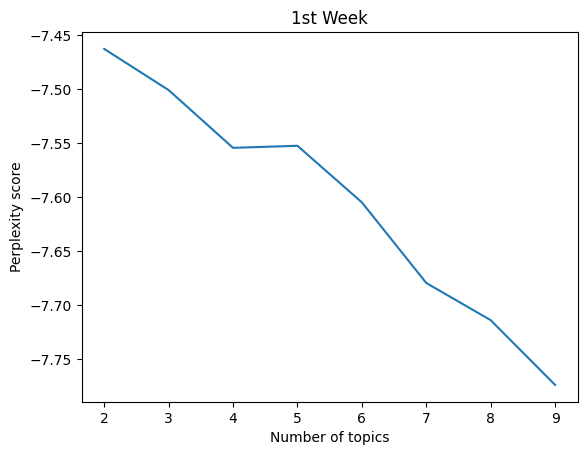

In [59]:
x = range(2,10)
plt.plot(x, perplexity_values1)
plt.title('1st Week')
plt.xlabel("Number of topics")
plt.ylabel("Perplexity score")
plt.show()

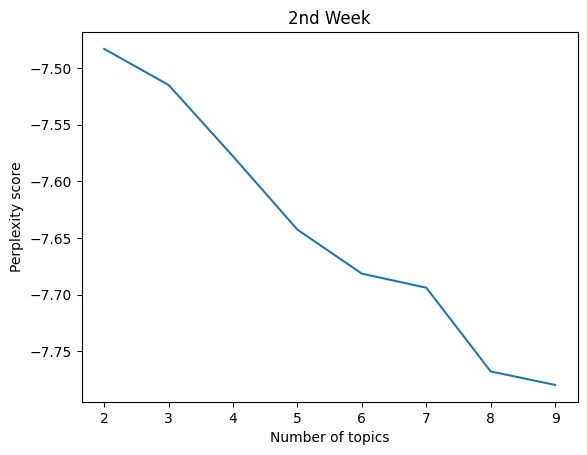

In [60]:
x = range(2,10)
plt.plot(x, perplexity_values2)
plt.title('2nd Week')
plt.xlabel("Number of topics")
plt.ylabel("Perplexity score")
plt.show()

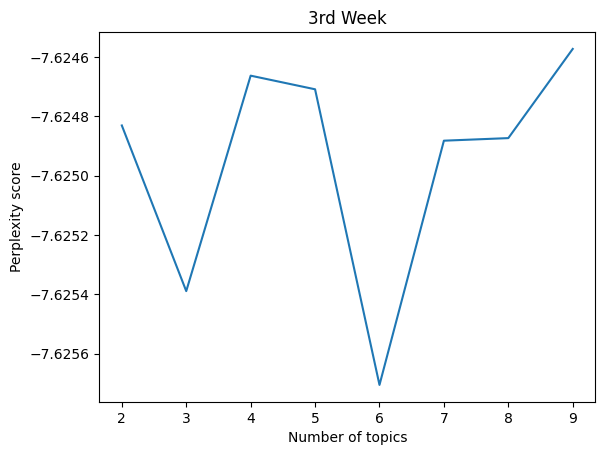

In [61]:
x = range(2,10)
plt.plot(x, perplexity_values3)
plt.title('3rd Week')
plt.xlabel("Number of topics")
plt.ylabel("Perplexity score")
plt.show()

In [62]:
coherence_values1 = []
for i in range(2,10):
    ldamodel1 = gensim.models.ldamodel.LdaModel(corpus1, num_topics=i, id2word=dictionary1, random_state=42)
    coherence_model_lda = CoherenceModel(model=ldamodel1, texts=terms1, dictionary=dictionary1, topn=10)
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_values1.append(coherence_lda)

In [63]:
coherence_values2 = []
for i in range(2,10):
    ldamodel2 = gensim.models.ldamodel.LdaModel(corpus2, num_topics=i, id2word=dictionary2, random_state=42)
    coherence_model_lda = CoherenceModel(model=ldamodel2, texts=terms2, dictionary=dictionary2, topn=10)
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_values2.append(coherence_lda)

In [64]:
coherence_values3 = []
for i in range(2,10):
    ldamodel3 = gensim.models.ldamodel.LdaModel(corpus3, num_topics=i, id2word=dictionary3, random_state=42)
    coherence_model_lda = CoherenceModel(model=ldamodel3, texts=terms3, dictionary=dictionary3, topn=10)
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_values3.append(coherence_lda)

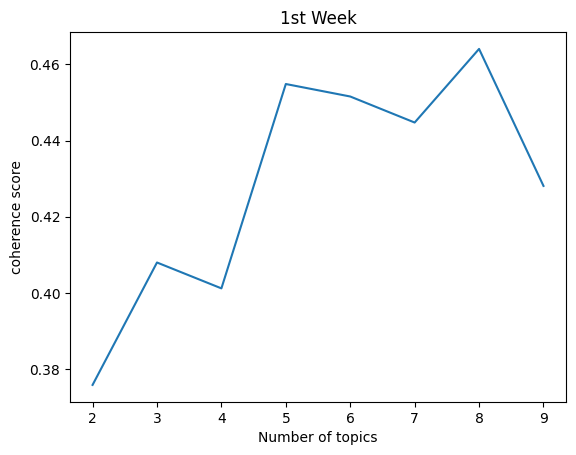

In [65]:
x = range(2,10)
plt.plot(x, coherence_values1)
plt.title('1st Week')
plt.xlabel("Number of topics")
plt.ylabel("coherence score")
plt.show()

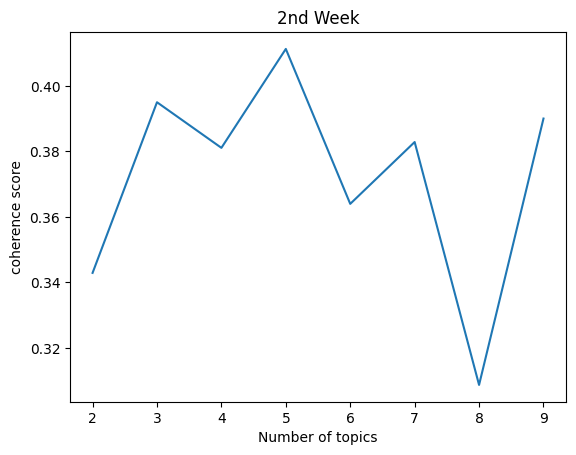

In [66]:
x = range(2,10)
plt.plot(x, coherence_values2)
plt.title('2nd Week')
plt.xlabel("Number of topics")
plt.ylabel("coherence score")
plt.show()

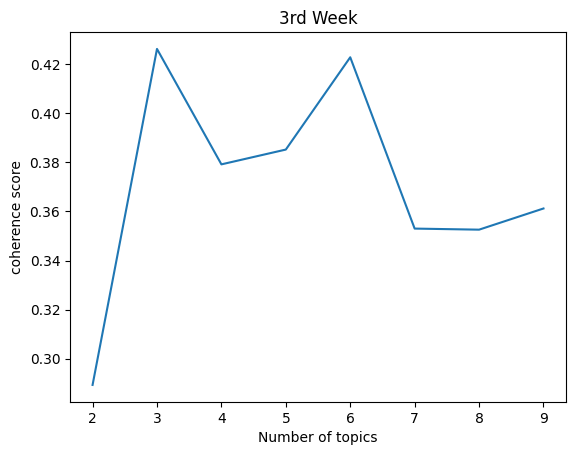

In [67]:
x = range(2,10)
plt.plot(x, coherence_values3)
plt.title('3rd Week')
plt.xlabel("Number of topics")
plt.ylabel("coherence score")
plt.show()

최종적으로 Perplexity와 Coherence Score를 동시에 고려하여 최적의 주제 수를 선택
</br>
일반적으로 Coherence Score가 더 중요한 평가 지표로 간주됩니다.

## I. 최종 LDA 분석

In [68]:
NUM_TOPICS_1 = 8
NUM_TOPICS_2 = 5
NUM_TOPICS_3 = 3

In [69]:
final_model_1 = gensim.models.LdaModel(
    corpus1,
    num_topics=NUM_TOPICS_1, # 출력 토픽 수
    id2word=dictionary1,
    random_state=42
)

In [70]:
final_model_2 = gensim.models.LdaModel(
    corpus2,
    num_topics=NUM_TOPICS_2, # 출력 토픽 수
    id2word=dictionary2,
    random_state=42
)

In [71]:
final_model_3 = gensim.models.LdaModel(
    corpus3,
    num_topics=NUM_TOPICS_3, # 출력 토픽 수
    id2word=dictionary3,
    random_state=42
)

In [72]:
# 각 토픽과 그 토픽에 속하는 단어를 중요도(확률)와 함께 출력
# num_topics: 출력할 토픽의 개수를 지정
# num_words: 각 토픽에서 상위 N개의 주요 단어 출력
final_model_1.show_topics(4, 10)

[(7,
  '0.011*"이스라엘" + 0.010*"정상" + 0.009*"사주" + 0.008*"필리핀" + 0.008*"뉴욕증시" + 0.008*"고려아연" + 0.008*"자" + 0.007*"과" + 0.006*"윤" + 0.006*"거짓말"'),
 (1,
  '0.012*"대통령" + 0.010*"윤" + 0.009*"이스라엘" + 0.009*"특검법" + 0.009*"이란" + 0.008*"전자" + 0.008*"삼성" + 0.008*"영업" + 0.007*"공격" + 0.007*"부결"'),
 (4,
  '0.020*"레바논" + 0.014*"국민" + 0.014*"도착" + 0.013*"수송기" + 0.013*"체류" + 0.013*"군" + 0.010*"휴학" + 0.010*"필리핀" + 0.009*"서울" + 0.008*"공항"'),
 (5,
  '0.015*"전자" + 0.010*"영업" + 0.010*"삼성" + 0.010*"매출" + 0.009*"익" + 0.009*"시바" + 0.009*"총리" + 0.008*"윤" + 0.006*"상승" + 0.006*"일제"')]

In [73]:
# 각 토픽과 그 토픽에 속하는 단어를 중요도(확률)와 함께 출력
# num_topics: 출력할 토픽의 개수를 지정
# num_words: 각 토픽에서 상위 N개의 주요 단어 출력
final_model_2.show_topics(4, 10)

[(0,
  '0.009*"대통령" + 0.008*"명태" + 0.008*"균" + 0.007*"무인기" + 0.007*"추가" + 0.006*"한강" + 0.006*"인하" + 0.005*"첫" + 0.005*"윤" + 0.004*"회의"'),
 (4,
  '0.015*"한국" + 0.011*"평양" + 0.010*"무인기" + 0.009*"노벨" + 0.008*"정부" + 0.007*"한강" + 0.007*"침투" + 0.007*"경제" + 0.007*"윤" + 0.006*"대통령실"'),
 (2,
  '0.012*"한국" + 0.010*"북한" + 0.009*"합참" + 0.008*"한강" + 0.006*"무인기" + 0.005*"주가" + 0.005*"간" + 0.005*"전망" + 0.004*"국민" + 0.004*"군수"'),
 (1,
  '0.023*"한강" + 0.016*"노벨문학상" + 0.015*"수상" + 0.011*"대통령" + 0.011*"한국" + 0.010*"무인기" + 0.009*"평양" + 0.008*"합참" + 0.008*"폭파" + 0.008*"북"')]

In [74]:
# 각 토픽과 그 토픽에 속하는 단어를 중요도(확률)와 함께 출력
# num_topics: 출력할 토픽의 개수를 지정
# num_words: 각 토픽에서 상위 N개의 주요 단어 출력
final_model_3.show_topics(4, 10)

[(0,
  '0.011*"여사" + 0.010*"대통령" + 0.008*"대통령실" + 0.007*"김" + 0.006*"한국" + 0.006*"경찰" + 0.006*"출석" + 0.006*"윤" + 0.006*"김건희" + 0.005*"검찰"'),
 (1,
  '0.019*"한동훈" + 0.017*"대통령" + 0.014*"윤" + 0.012*"면담" + 0.011*"경제" + 0.010*"대통령실" + 0.010*"대표" + 0.007*"사망" + 0.007*"파병" + 0.006*"여사"'),
 (2,
  '0.017*"파병" + 0.016*"북한" + 0.011*"러시아" + 0.008*"국정원" + 0.007*"대통령실" + 0.006*"일정" + 0.006*"김건희" + 0.005*"대통령" + 0.005*"오자" + 0.005*"한동훈"')]

In [75]:
TOP_N = 20

In [76]:
final_word_dict_1 = {}
for i in range(NUM_TOPICS_1):
  final_words_1 = final_model_1.show_topic(i, topn=TOP_N)
  final_word_dict_1['Topic #' + '{:02d}'.format(i+1)] = [i[0] for i in final_words_1]
  final_word_df_1 = pd.DataFrame(final_word_dict_1)

In [77]:
final_word_dict_2 = {}
for i in range(NUM_TOPICS_2):
  final_words_2 = final_model_2.show_topic(i, topn=TOP_N)
  final_word_dict_2['Topic #' + '{:02d}'.format(i+1)] = [i[0] for i in final_words_2]
  final_word_df_2 = pd.DataFrame(final_word_dict_2)

In [78]:
final_word_dict_3 = {}
for i in range(NUM_TOPICS_3):
  final_words_3 = final_model_3.show_topic(i, topn=TOP_N)
  final_word_dict_3['Topic #' + '{:02d}'.format(i+1)] = [i[0] for i in final_words_3]
  final_word_df_3 = pd.DataFrame(final_word_dict_3)

In [79]:
final_word_df_1

,Topic #01,Topic #02,Topic #03,Topic #04,Topic #05,Topic #06,Topic #07,Topic #08
0,대통령,대통령,대통령,대통령,레바논,전자,레바논,이스라엘
1,윤,윤,이스라엘,윤,국민,영업,고려아연,정상
2,필리핀,이스라엘,대응,김건희,도착,삼성,판매,사주
3,싱가포르,특검법,민주,위,수송기,매출,코스피,필리핀
4,방문,이란,윤,대통령실,체류,익,이스라엘,뉴욕증시
5,이란,전자,혁신,여사,군,시바,대통령,고려아연
6,이스라엘,삼성,헤즈볼라,개월,휴학,총리,공개매수,자
7,사업,영업,음주운전,가을,필리핀,윤,떡,과
8,쓰레기,공격,다혜씨,북한,서울,상승,허리케인,윤
9,풍선,부결,입건,국악,공항,일제,정확,거짓말


In [80]:
final_word_df_2

,Topic #01,Topic #02,Topic #03,Topic #04,Topic #05
0,대통령,한강,한국,한강,한국
1,명태,노벨문학상,북한,당선,평양
2,균,수상,합참,국민,무인기
3,무인기,대통령,한강,최고,노벨
4,추가,한국,무인기,유력,정부
5,한강,무인기,주가,감독,한강
6,인하,평양,간,확보,침투
7,첫,합참,전망,영풍,경제
8,윤,폭파,국민,노벨문학상,윤
9,회의,북,군수,진보당,대통령실


In [81]:
final_word_df_3

,Topic #01,Topic #02,Topic #03
0,여사,한동훈,파병
1,대통령,대통령,북한
2,대통령실,윤,러시아
3,김,면담,국정원
4,한국,경제,대통령실
5,경찰,대통령실,일정
6,출석,대표,김건희
7,윤,사망,대통령
8,김건희,파병,오자
9,검찰,여사,한동훈


In [82]:
final_model_1.print_topics(num_words=5)

[(0, '0.023*"대통령" + 0.016*"윤" + 0.013*"필리핀" + 0.011*"싱가포르" + 0.009*"방문"'),
 (1, '0.012*"대통령" + 0.010*"윤" + 0.009*"이스라엘" + 0.009*"특검법" + 0.009*"이란"'),
 (2, '0.011*"대통령" + 0.010*"이스라엘" + 0.009*"대응" + 0.009*"민주" + 0.008*"윤"'),
 (3, '0.017*"대통령" + 0.015*"윤" + 0.010*"김건희" + 0.008*"위" + 0.007*"대통령실"'),
 (4, '0.020*"레바논" + 0.014*"국민" + 0.014*"도착" + 0.013*"수송기" + 0.013*"체류"'),
 (5, '0.015*"전자" + 0.010*"영업" + 0.010*"삼성" + 0.010*"매출" + 0.009*"익"'),
 (6, '0.010*"레바논" + 0.007*"고려아연" + 0.007*"판매" + 0.007*"코스피" + 0.007*"이스라엘"'),
 (7, '0.011*"이스라엘" + 0.010*"정상" + 0.009*"사주" + 0.008*"필리핀" + 0.008*"뉴욕증시"')]

In [83]:
final_model_2.print_topics(num_words=5)

[(0, '0.009*"대통령" + 0.008*"명태" + 0.008*"균" + 0.007*"무인기" + 0.007*"추가"'),
 (1, '0.023*"한강" + 0.016*"노벨문학상" + 0.015*"수상" + 0.011*"대통령" + 0.011*"한국"'),
 (2, '0.012*"한국" + 0.010*"북한" + 0.009*"합참" + 0.008*"한강" + 0.006*"무인기"'),
 (3, '0.006*"한강" + 0.006*"당선" + 0.005*"국민" + 0.005*"최고" + 0.005*"유력"'),
 (4, '0.015*"한국" + 0.011*"평양" + 0.010*"무인기" + 0.009*"노벨" + 0.008*"정부"')]

In [84]:
final_model_3.print_topics(num_words=5)

[(0, '0.011*"여사" + 0.010*"대통령" + 0.008*"대통령실" + 0.007*"김" + 0.006*"한국"'),
 (1, '0.019*"한동훈" + 0.017*"대통령" + 0.014*"윤" + 0.012*"면담" + 0.011*"경제"'),
 (2, '0.017*"파병" + 0.016*"북한" + 0.011*"러시아" + 0.008*"국정원" + 0.007*"대통령실"')]

In [85]:
# 문서의 토픽 분포를 반환 = (토픽 번호, 확률)
for i in range(9):
    print(final_model_1.get_document_topics(corpus1)[i])

[(0, 0.01390127), (1, 0.9026553), (2, 0.013893259), (3, 0.0139050735), (4, 0.013921399), (5, 0.0138949575), (6, 0.013920328), (7, 0.013908443)]
[(0, 0.010432544), (1, 0.9270083), (2, 0.01041954), (3, 0.010421827), (4, 0.0104381265), (5, 0.010421058), (6, 0.010422896), (7, 0.010435742)]
[(0, 0.011367118), (1, 0.011370474), (2, 0.011365099), (3, 0.011365267), (4, 0.011375792), (5, 0.9204239), (6, 0.011366722), (7, 0.011365618)]
[(0, 0.015629511), (1, 0.015638493), (2, 0.8905716), (3, 0.015630981), (4, 0.01562809), (5, 0.015631521), (6, 0.01563114), (7, 0.015638642)]
[(0, 0.017864536), (1, 0.87488544), (2, 0.017870063), (3, 0.01786207), (4, 0.017901322), (5, 0.017864624), (6, 0.017876465), (7, 0.017875481)]
[(0, 0.02084624), (1, 0.020872949), (2, 0.020842975), (3, 0.020840947), (4, 0.02083449), (5, 0.8540768), (6, 0.020849824), (7, 0.020835793)]
[(0, 0.013894498), (1, 0.013897814), (2, 0.013899564), (3, 0.902708), (4, 0.013896716), (5, 0.013891228), (6, 0.013914162), (7, 0.013898095)]
[(0

In [86]:
# 문서의 토픽 분포를 반환 = (토픽 번호, 확률)
for i in range(9):
    print(final_model_2.get_document_topics(corpus2)[i])

[(0, 0.8843089), (1, 0.02907487), (2, 0.028600706), (3, 0.028693572), (4, 0.029321965)]
[(0, 0.018222881), (1, 0.018461494), (2, 0.01853398), (3, 0.01839229), (4, 0.92638934)]
[(0, 0.025035283), (1, 0.025921365), (2, 0.8988747), (3, 0.025094664), (4, 0.025073977)]
[(0, 0.022318564), (1, 0.9108642), (2, 0.022299347), (3, 0.022230359), (4, 0.022287518)]
[(0, 0.020174975), (1, 0.020070272), (2, 0.020018842), (3, 0.02005002), (4, 0.9196859)]
[(0, 0.029017748), (1, 0.02868796), (2, 0.028974533), (3, 0.8839726), (4, 0.029347166)]
[(0, 0.022242358), (1, 0.90997833), (2, 0.02229122), (3, 0.022400016), (4, 0.023088012)]
[(0, 0.016811226), (1, 0.016831396), (2, 0.016680146), (3, 0.016764674), (4, 0.9329126)]
[(0, 0.018215412), (1, 0.018375503), (2, 0.92658347), (3, 0.018279854), (4, 0.018545737)]


In [87]:
# 문서의 토픽 분포를 반환 = (토픽 번호, 확률)
for i in range(9):
    print(final_model_3.get_document_topics(corpus3)[i])

[(0, 0.044081), (1, 0.91290015), (2, 0.043018837)]
[(0, 0.034319915), (1, 0.9316942), (2, 0.03398594)]
[(0, 0.034360327), (1, 0.9292038), (2, 0.03643588)]
[(0, 0.85805035), (1, 0.07453667), (2, 0.06741297)]
[(0, 0.059589818), (1, 0.8394241), (2, 0.10098611)]
[(0, 0.91050094), (1, 0.0459362), (2, 0.043562844)]
[(0, 0.9112255), (1, 0.043865975), (2, 0.044908524)]
[(0, 0.0632791), (1, 0.33405313), (2, 0.6026678)]
[(0, 0.069776006), (1, 0.075477555), (2, 0.85474646)]


## G. 최종 pyLDAvis 시각화

In [88]:
pyLDAvis.enable_notebook()

In [89]:
#data = pyLDAvis.gensim.prepare(model, corpus, dictionary)
final_data_1 = pyLDAvis.gensim_models.prepare(final_model_1, corpus1, dictionary1)

final_data_1

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.157365 -0.049001       1        1  15.560380
1     -0.015479  0.064884       2        1  15.060946
0     -0.102862 -0.046632       3        1  13.271128
3     -0.030060 -0.156796       4        1  13.100313
7     -0.126299  0.042252       5        1  11.148790
2     -0.010632  0.058486       6        1  11.091701
6      0.060778  0.104327       7        1  10.497840
5      0.067189 -0.017520       8        1  10.268902, topic_info=     Term       Freq      Total Category  logprob  loglift
478    전자  20.000000  20.000000  Default  30.0000  30.0000
1163   체류  13.000000  13.000000  Default  29.0000  29.0000
1713   영업  14.000000  14.000000  Default  28.0000  28.0000
431   수송기  16.000000  16.000000  Default  27.0000  27.0000
477    삼성  17.000000  17.000000  Default  26.0000  26.0000
...   ...        ...        ...      ...      ...      ...
74    대통령   3.089858  60.414353   Topic8  -5.2599  -0.6971
2     레바논   2.713831  38.698425   Topic8  -5.3896  -0.3814
202    협력   2.340413  10.847681   Topic8  -5.5377   0.7424
431   수송기   2.340354  16.124570   Topic8  -5.5377   0.3460
236     위   2.340237  13.815264   Topic8  -5.5378   0.5005

[481 rows x 6 columns], token_table=      Topic      Freq Term
term                      
760       1  0.140787   가을
760       4  0.703936   가을
760       6  0.140787   가을
1668      6  0.626292    감
716       2  0.151658   감소
...     ...       ...  ...
1198      4  0.076066   휴학
1198      6  0.076066   휴학
1198      8  0.076066   휴학
220       2  0.542129   흑자
220       7  0.271064   흑자

[985 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 1, 4, 8, 3, 7, 6])

In [90]:
#data = pyLDAvis.gensim.prepare(model, corpus, dictionary)
final_data_2 = pyLDAvis.gensim_models.prepare(final_model_2, corpus2, dictionary2)

final_data_2

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.086561 -0.033874       1        1  23.891434
1      0.104198  0.028267       2        1  23.176296
0     -0.057677  0.126605       3        1  19.484322
2     -0.080461 -0.033125       4        1  18.446127
3     -0.052620 -0.087872       5        1  15.001821, topic_info=      Term       Freq      Total Category  logprob  loglift
48      수상  31.000000  31.000000  Default  30.0000  30.0000
440  노벨문학상  34.000000  34.000000  Default  29.0000  29.0000
56      한국  50.000000  50.000000  Default  28.0000  28.0000
22      합참  22.000000  22.000000  Default  27.0000  27.0000
427     정부  18.000000  18.000000  Default  26.0000  26.0000
..     ...        ...        ...      ...      ...      ...
114    한반도   3.101248   9.717277   Topic5  -5.6532   0.7549
440  노벨문학상   3.923398  34.684282   Topic5  -5.4181  -0.2823
0      대통령   3.874086  37.793514   Topic5  -5.4307  -0.3808
793   기준금리   2.958987  13.582673   Topic5  -5.7002   0.3731
59    고려아연   2.956060   9.646746   Topic5  -5.7012   0.7142

[359 rows x 6 columns], token_table=      Topic      Freq Term
term                      
1250      4  0.854450    간
118       3  0.211535   감독
118       4  0.317302   감독
118       5  0.423070   감독
577       1  0.281440   개월
...     ...       ...  ...
74        3  0.586868   회의
165       4  0.780404   획기
165       5  0.195101   획기
972       1  0.775005   후보
972       2  0.129168   후보

[645 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 1, 3, 4])

In [91]:
#data = pyLDAvis.gensim.prepare(model, corpus, dictionary)
final_data_3 = pyLDAvis.gensim_models.prepare(final_model_3, corpus3, dictionary3)

final_data_3

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.081149 -0.046468       1        1  37.745600
0     -0.087313 -0.037276       2        1  32.647679
2      0.006164  0.083744       3        1  29.606721, topic_info=    Term       Freq      Total Category  logprob  loglift
10    면담  21.000000  21.000000  Default  30.0000  30.0000
178   북한  28.000000  28.000000  Default  29.0000  29.0000
75    파병  37.000000  37.000000  Default  28.0000  28.0000
82   한동훈  42.000000  42.000000  Default  27.0000  27.0000
565   경제  24.000000  24.000000  Default  26.0000  26.0000
..   ...        ...        ...      ...      ...      ...
460  다음주   4.044165   9.623928   Topic3  -5.7754   0.3502
45   불기소   4.220836  14.072850   Topic3  -5.7326   0.0130
113   경찰   4.209826  14.705190   Topic3  -5.7352  -0.0336
425   성장   3.939280   8.948253   Topic3  -5.8016   0.3967
136    윤   3.954142  35.907126   Topic3  -5.7979  -0.9890

[208 rows x 6 columns], token_table=      Topic      Freq Term
term                      
42        1  0.085011   검찰
42        2  0.595079   검찰
42        3  0.255034   검찰
565       1  0.791041   경제
565       2  0.166535   경제
...     ...       ...  ...
83        2  0.156627   활동
83        3  0.078313   활동
422       1  0.623558   회의
422       2  0.178160   회의
422       3  0.089080   회의

[302 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3])